In [23]:
import numpy as np
import pandas as pd
import utils

import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import randint, uniform
import os
import json
import pickle

XY = pd.read_csv("sp500/data_xy.csv").set_index(keys=["quarter", "ticker"], drop=True)
CREDIT_DATA = pd.read_csv('credit_data/credit_data.csv').set_index(keys='quarter', drop=True)
XY = XY.join(CREDIT_DATA, on='quarter', how='left')

decision_attrs = [
    "price",
    "log_return_q1",
    "log_return_q2",
    "log_return_q3",
    "log_return_q4",
    "diff_q1",
    "diff_q2",
    "diff_q3",
    "diff_q4",
    "class_1_q1",
    "class_1_q2",
    "class_1_q3",
    "class_1_q4",
    "class_2_q1",
    "class_2_q2",
    "class_2_q3",
    "class_2_q4",
]

model_decision_attrs = [
    "class_1_q1",
    "class_1_q2",
    "class_1_q3",
    "class_1_q4",
    "class_2_q1",
    "class_2_q2",
    "class_2_q3",
    "class_2_q4",
]


In [24]:
%load_ext autoreload
%autoreload 2

In [53]:
def train_and_evaluate_classifiers(X, Y, test_size=0.2, random_state=42, verbose=0, n_splits=5, n_iter=5):
    decision_attr = Y.to_frame().columns[0]
    splitter = utils.TemporalBalancedSplitter(test_size=test_size, random_state=random_state)
    X_train, X_test, y_train, y_test = splitter.split_data(X, Y)
    start_q, end_q = y_test.index[0][0], y_test.index[-1][0]
    print(f"Testing for {end_q-start_q} quarters ahead")
    min_estimators = len(X.columns) * 10
    max_estimators = len(X.columns) * 12   
    print(min_estimators, max_estimators)
    
    classifiers = {
         'XGBoost': (
            Pipeline([
                ('scaler', StandardScaler()),
                ('clf', XGBClassifier(random_state=random_state))
            ]),
            {
                'clf__n_estimators': randint(min_estimators, max_estimators),
                'clf__max_depth': randint(6, 15),
                'clf__learning_rate': uniform(0.01, 0.19),  # from 0.01 to 0.2
                'clf__min_child_weight': randint(3, 9),
                'clf__subsample': uniform(0.7, 0.3),        # from 0.7 to 1.0
                'clf__colsample_bytree': uniform(0.6, 0.4)  # from 0.6 to 1.0
            }
        ),
        'RandomForestClassifier': (
            Pipeline(
                [
                    ('scaler', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=random_state))
                ]),
            {
                'clf__n_estimators': randint(min_estimators, max_estimators),
                'clf__max_depth': randint(6, 15),
                'clf__min_samples_split': randint(5, 15),
                'clf__min_samples_leaf': randint(2, 8),
                'clf__max_features': uniform(0.2, 0.6) 
            }
        ),
    }
    
    results = {}
    
    # Train and evaluate each classifier
    for name, (classifier, param_grid) in classifiers.items():
        print(f"\nTraining {name}...")
        grid_search = RandomizedSearchCV(
            classifier,
            param_grid,
            cv=utils.BalancedQuarterTimeSeriesSplit(n_splits=n_splits, test_size=4),
            scoring='f1',
            n_jobs=-1,
            verbose=verbose,
            n_iter=n_iter,
            random_state=random_state
        )

        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        
        results[name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'test_accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_score': f1,
            'predictions': y_pred
        }

        dt_stamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        dir_name = f"models/{name}-{decision_attr}-{str(f1).replace(".","")[:4]}-{dt_stamp}"
        os.makedirs(dir_name, exist_ok=True)

        with open(f"{dir_name}/report.txt", "w") as f:
            f.write(str(results[name]['classification_report']))

        with open(f"{dir_name}/parameters.json", "w") as f:
            f.write(
                json.dumps({"parameters": list(X.columns)})
            )
        with open(f"{dir_name}/feature_importance.json", "w") as f:
            #forest.feature_importances_
            if isinstance(grid_search.best_estimator_.named_steps['clf'], RandomForestClassifier):
                x = {} # a dict to hold feature_name: feature_importance
                for feature, importance in zip(X.columns, grid_search.best_estimator_.named_steps['clf'].feature_importances_):
                    x[feature] = importance #add the name/value pair
            else:
                x = grid_search.best_estimator_.named_steps['clf'].get_booster().get_score(importance_type='weight')
            f.write(
                json.dumps({k: v for k, v in sorted(x.items(), key=lambda item: item[1])})
            )
        pickle.dump(grid_search.best_estimator_, open(f"{dir_name}/model.pkl",'wb'))
        print(f"SAVED in {dir_name}/model.pkl")
        
        print(f"\nBest parameters for {name}:")
        print(results[name]['best_params'])
        print(f"\nTest f1_score for {name}: {results[name]['f1_score']:.4f}")
        print(f"\nClassification Report for {name}:")
        print(results[name]['classification_report'])
    
    return results, X_test, y_test

def plot_results(results, X_test, y_test, decision_attr):
    # Plot accuracy comparison
    plt.figure(figsize=(12, 6))
    accuracies = [results[name]['test_accuracy'] for name in results.keys()]
    plt.bar(results.keys(), accuracies)
    plt.title(f'Model Accuracy Comparison for {decision_attr} model')
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrices with clear winner/loser labels
    n_classifiers = len(results)
    n_rows = (n_classifiers + 2) // 3  # Ceiling division to get enough rows
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.ravel()
    
    classes = ['Loser (0)', 'Winner (1)']
    
    for idx, (name, result) in enumerate(results.items()):
        cm = result['confusion_matrix']
        
        # Create confusion matrix plot with seaborn
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            ax=axes[idx],
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes
        )
        
        axes[idx].set_title(f'{name} Confusion Matrix for {decision_attr} model')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        
        # Add text annotations explaining the quadrants
        axes[idx].text(-0.2, -0.1, 
                      'TN: Correctly\nPredicted Losers', 
                      transform=axes[idx].transAxes,
                      fontsize=8)
        axes[idx].text(0.8, -0.1, 
                      'FP: Losers Predicted\nas Winners', 
                      transform=axes[idx].transAxes,
                      fontsize=8)
        axes[idx].text(-0.2, 0.9, 
                      'FN: Winners Predicted\nas Losers', 
                      transform=axes[idx].transAxes,
                      fontsize=8)
        axes[idx].text(0.8, 0.9, 
                      'TP: Correctly\nPredicted Winners', 
                      transform=axes[idx].transAxes,
                      fontsize=8)
    
    # Hide any unused subplots
    for idx in range(len(results), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Add a summary of key metrics for each class
    for name, result in results.items():
        print(f"\nDetailed metrics for {name} prediction {decision_attr}:")
        report_dict = classification_report(
            y_test, 
            result['predictions'], 
            target_names=['Loser (0)', 'Winner (1)'], 
            output_dict=True
        )
        
        # Create a prettier format for the metrics
        metrics_df = pd.DataFrame({
            'Class': ['Loser (0)', 'Winner (1)'],
            'Precision': [report_dict['Loser (0)']['precision'], 
                         report_dict['Winner (1)']['precision']],
            'Recall': [report_dict['Loser (0)']['recall'], 
                      report_dict['Winner (1)']['recall']],
            'F1-Score': [report_dict['Loser (0)']['f1-score'], 
                        report_dict['Winner (1)']['f1-score']],
            'Support': [report_dict['Loser (0)']['support'], 
                       report_dict['Winner (1)']['support']]
        }).set_index('Class')
        
        print(metrics_df.round(3))
        print("\nConfusion Matrix Interpretation:")
        cm = result['confusion_matrix']
        print(f"True Negatives (Correctly Predicted Losers): {cm[0,0]}")
        print(f"False Positives (Losers Predicted as Winners): {cm[0,1]}")
        print(f"False Negatives (Winners Predicted as Losers): {cm[1,0]}")
        print(f"True Positives (Correctly Predicted Winners): {cm[1,1]}")

class_1_q1
p= 75
n= 29459
Testing for 12 quarters ahead
750 900

Training XGBoost...
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END clf__colsample_bytree=0.6833842149435371, clf__learning_rate=0.10151940173503951, clf__max_depth=10, clf__min_child_weight=6, clf__n_estimators=834, clf__subsample=0.9540126957122921;, score=0.544 total time=   1.3s
[CV 1/4] END clf__colsample_bytree=0.9573240735248709, clf__learning_rate=0.05458115407301379, clf__max_depth=14, clf__min_child_weight=5, clf__n_estimators=843, clf__subsample=0.7031580622948325;, score=0.555 total time=   2.2s
[CV 1/4] END clf__colsample_bytree=0.8244814786651999, clf__learning_rate=0.16460797560888732, clf__max_depth=11, clf__min_child_weight=6, clf__n_estimators=834, clf__subsample=0.7018422599038294;, score=0.550 total time=   1.1s
[CV 2/4] END clf__colsample_bytree=0.6833842149435371, clf__learning_rate=0.10151940173503951, clf__max_depth=10, clf__min_child_weight=6, clf__n_estimators=834, clf__s

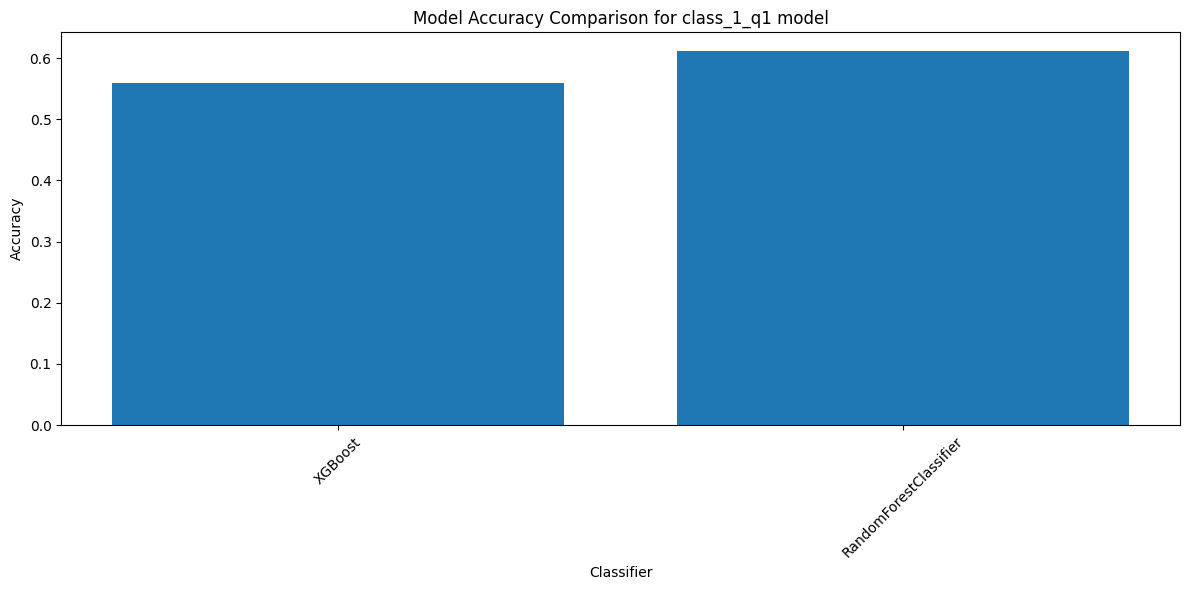

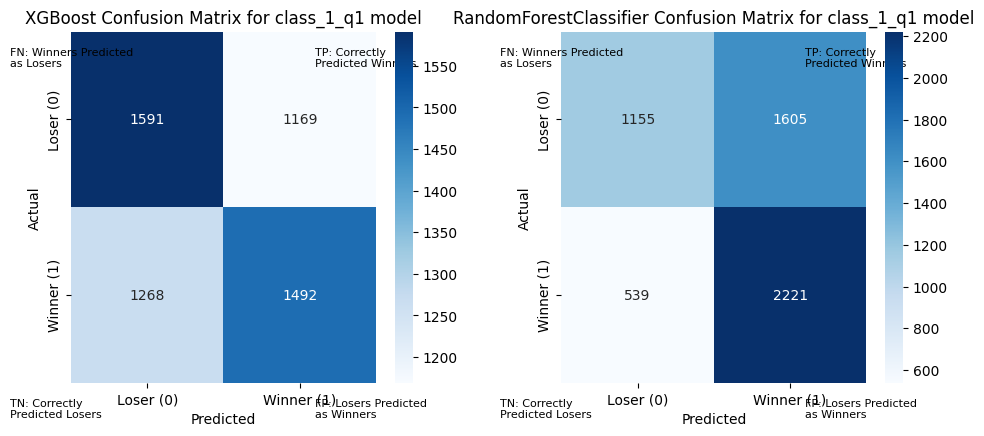


Detailed metrics for XGBoost prediction class_1_q1:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.556   0.576     0.566   2760.0
Winner (1)      0.561   0.541     0.550   2760.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 1591
False Positives (Losers Predicted as Winners): 1169
False Negatives (Winners Predicted as Losers): 1268
True Positives (Correctly Predicted Winners): 1492

Detailed metrics for RandomForestClassifier prediction class_1_q1:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.682   0.418     0.519   2760.0
Winner (1)      0.581   0.805     0.674   2760.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 1155
False Positives (Losers Predicted as Winners): 1605
False Negatives (Winners Predicted as Losers): 539
True Positives (Correctly Predicted Winners): 2221
class_1_q2

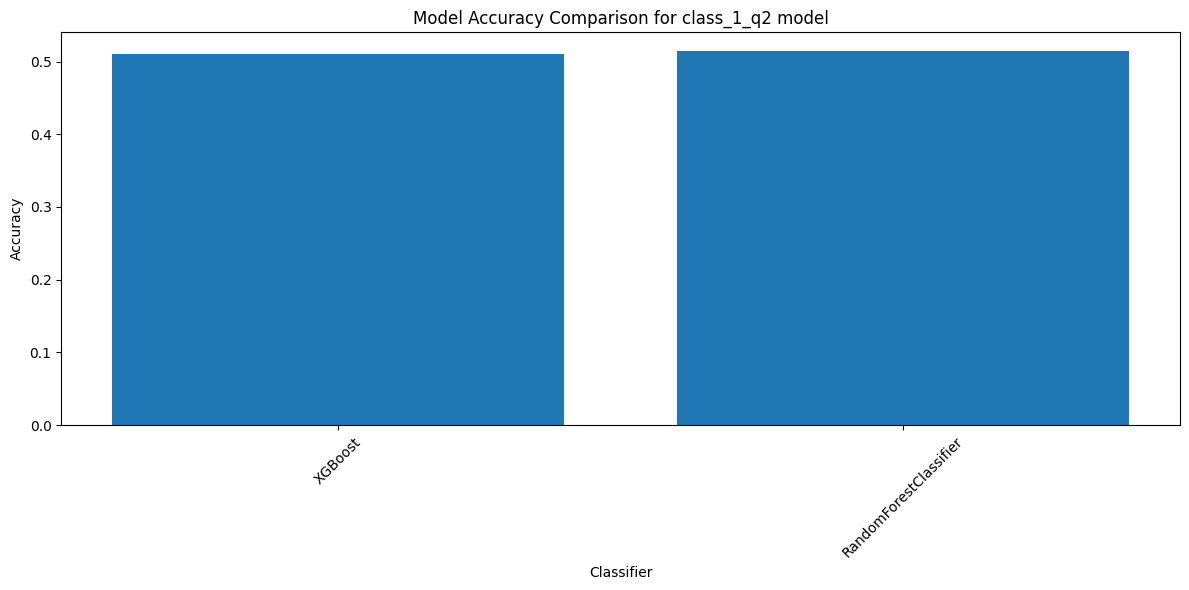

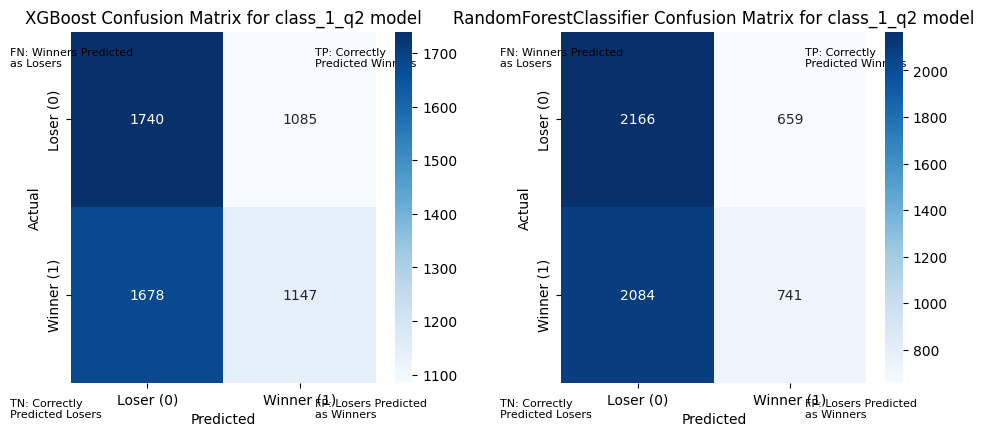


Detailed metrics for XGBoost prediction class_1_q2:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.509   0.616     0.557   2825.0
Winner (1)      0.514   0.406     0.454   2825.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 1740
False Positives (Losers Predicted as Winners): 1085
False Negatives (Winners Predicted as Losers): 1678
True Positives (Correctly Predicted Winners): 1147

Detailed metrics for RandomForestClassifier prediction class_1_q2:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.510   0.767     0.612   2825.0
Winner (1)      0.529   0.262     0.351   2825.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 2166
False Positives (Losers Predicted as Winners): 659
False Negatives (Winners Predicted as Losers): 2084
True Positives (Correctly Predicted Winners): 741
class_1_q3


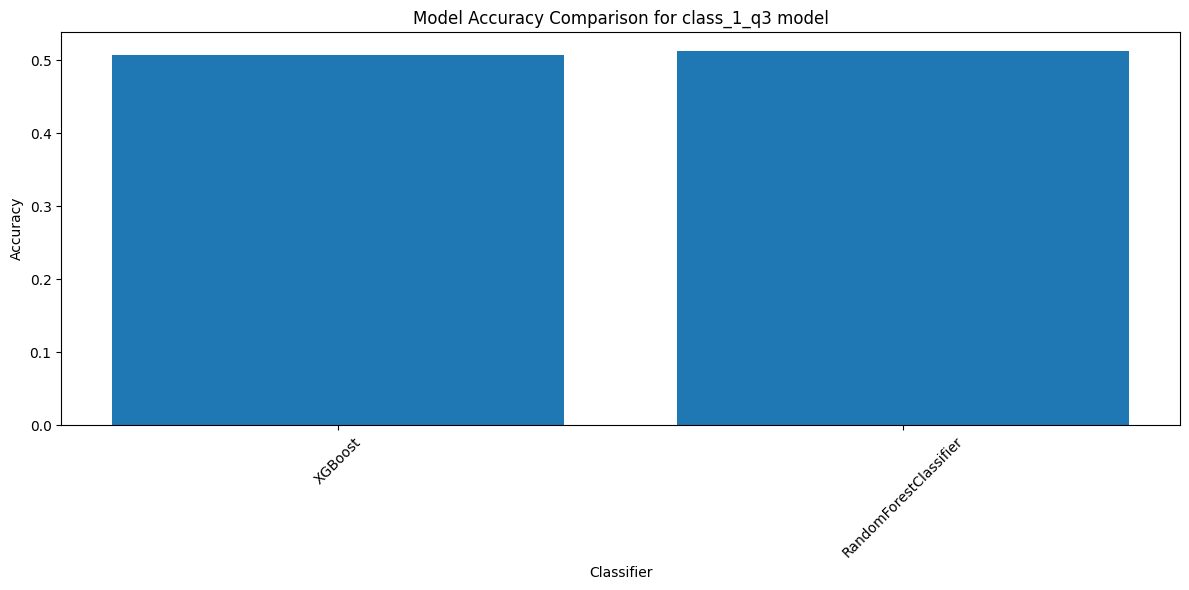

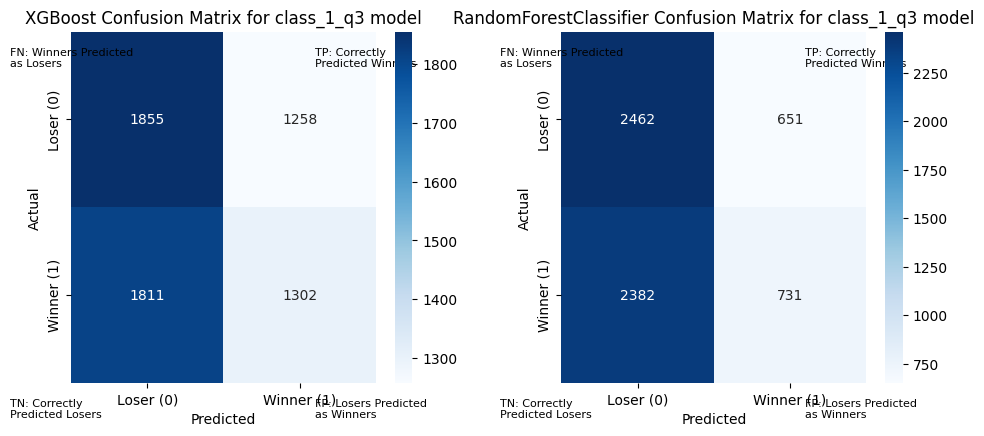


Detailed metrics for XGBoost prediction class_1_q3:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.506   0.596     0.547   3113.0
Winner (1)      0.509   0.418     0.459   3113.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 1855
False Positives (Losers Predicted as Winners): 1258
False Negatives (Winners Predicted as Losers): 1811
True Positives (Correctly Predicted Winners): 1302

Detailed metrics for RandomForestClassifier prediction class_1_q3:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.508   0.791     0.619   3113.0
Winner (1)      0.529   0.235     0.325   3113.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 2462
False Positives (Losers Predicted as Winners): 651
False Negatives (Winners Predicted as Losers): 2382
True Positives (Correctly Predicted Winners): 731
class_1_q4


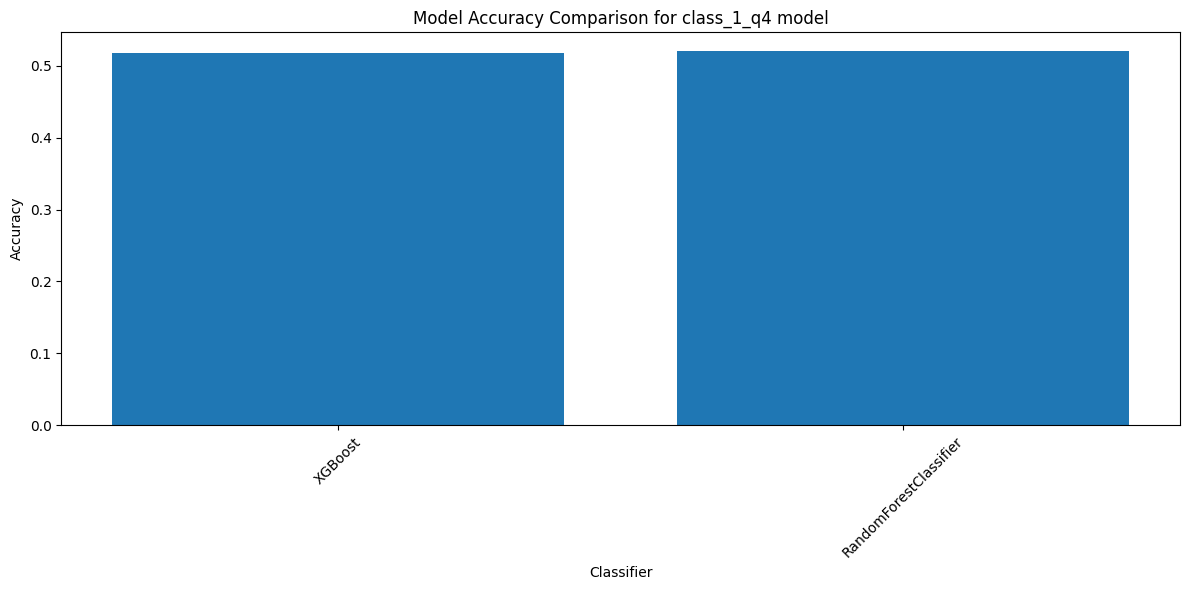

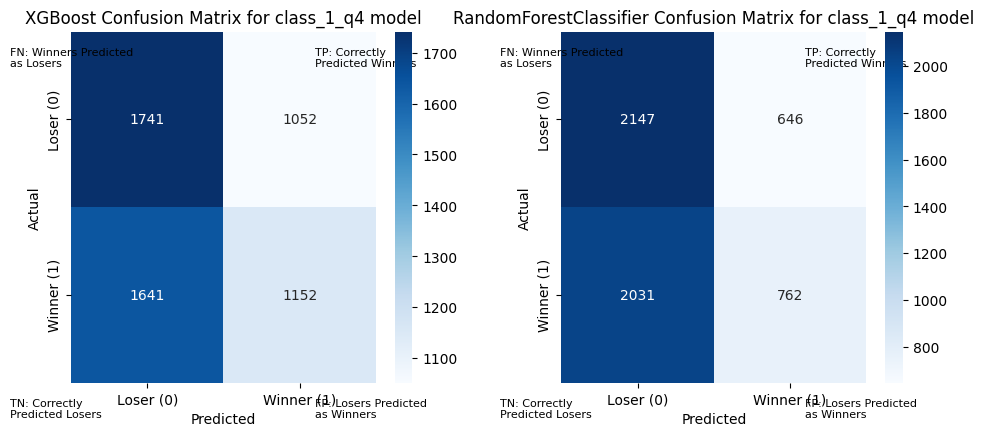


Detailed metrics for XGBoost prediction class_1_q4:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.515   0.623     0.564   2793.0
Winner (1)      0.523   0.412     0.461   2793.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 1741
False Positives (Losers Predicted as Winners): 1052
False Negatives (Winners Predicted as Losers): 1641
True Positives (Correctly Predicted Winners): 1152

Detailed metrics for RandomForestClassifier prediction class_1_q4:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.514   0.769     0.616   2793.0
Winner (1)      0.541   0.273     0.363   2793.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 2147
False Positives (Losers Predicted as Winners): 646
False Negatives (Winners Predicted as Losers): 2031
True Positives (Correctly Predicted Winners): 762
class_2_q1


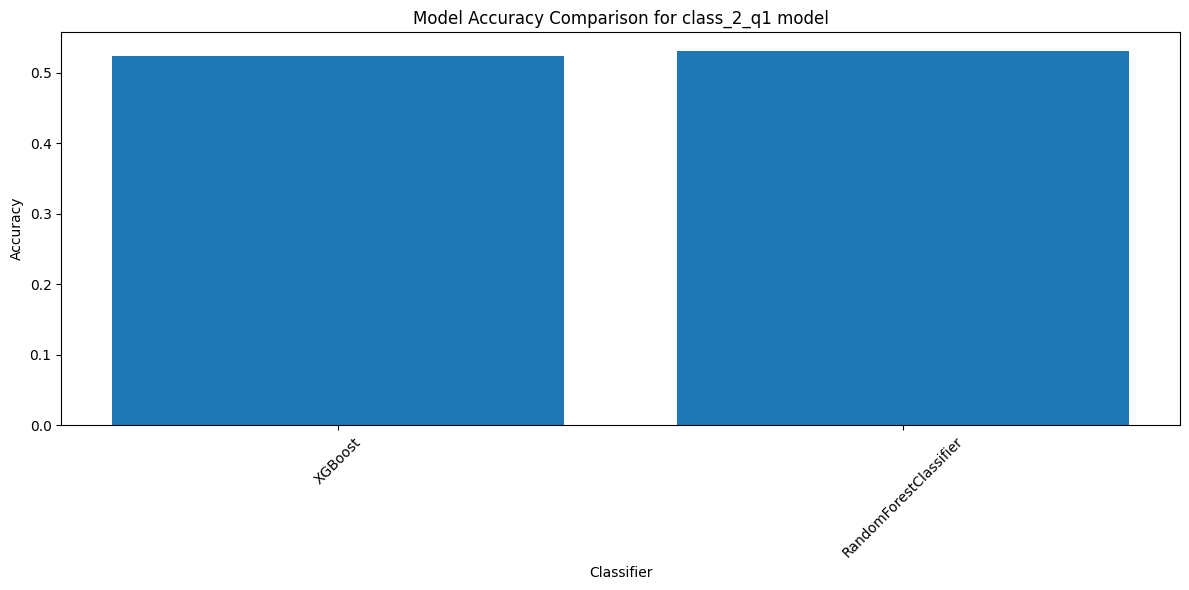

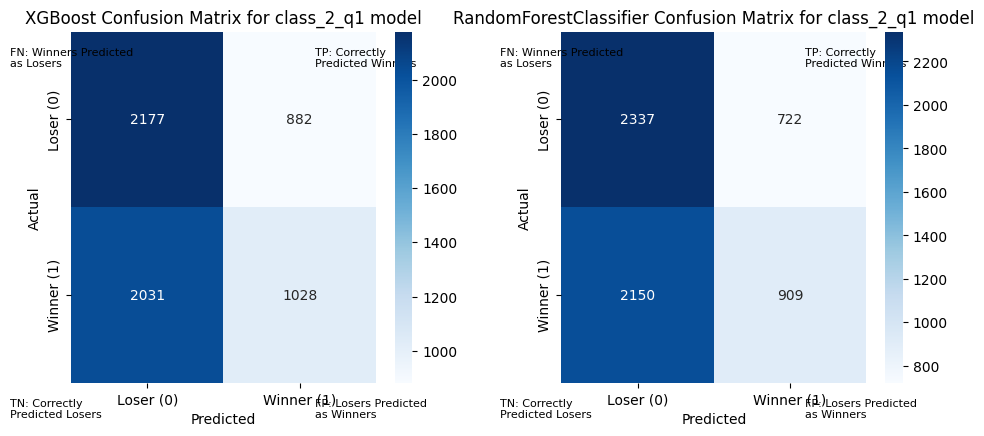


Detailed metrics for XGBoost prediction class_2_q1:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.517   0.712     0.599   3059.0
Winner (1)      0.538   0.336     0.414   3059.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 2177
False Positives (Losers Predicted as Winners): 882
False Negatives (Winners Predicted as Losers): 2031
True Positives (Correctly Predicted Winners): 1028

Detailed metrics for RandomForestClassifier prediction class_2_q1:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.521   0.764     0.619   3059.0
Winner (1)      0.557   0.297     0.388   3059.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 2337
False Positives (Losers Predicted as Winners): 722
False Negatives (Winners Predicted as Losers): 2150
True Positives (Correctly Predicted Winners): 909
class_2_q2
p

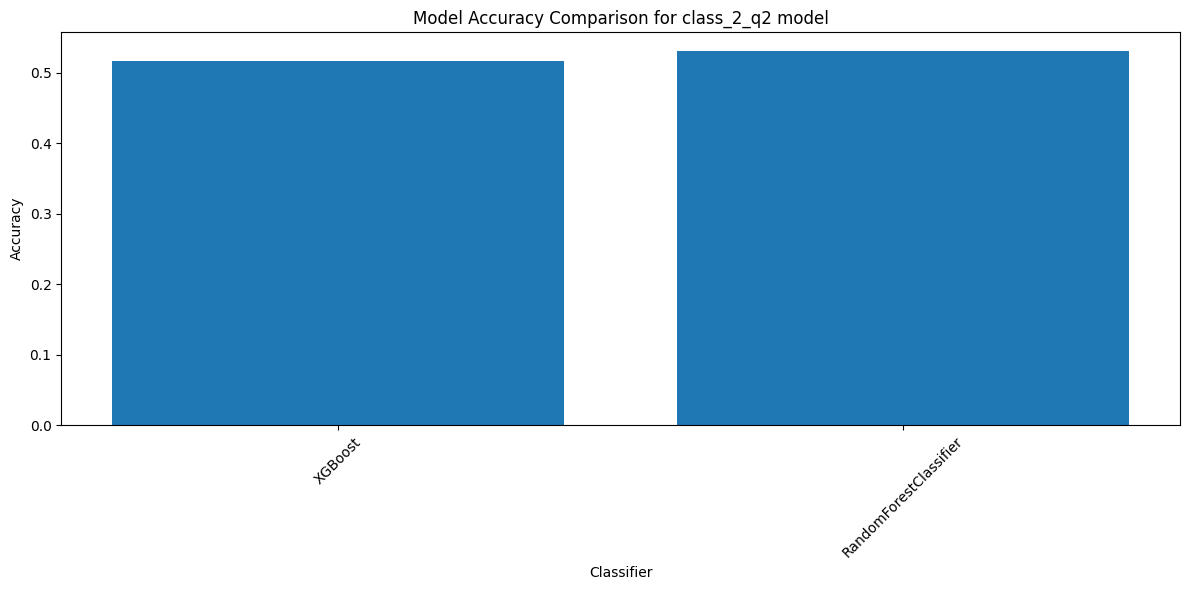

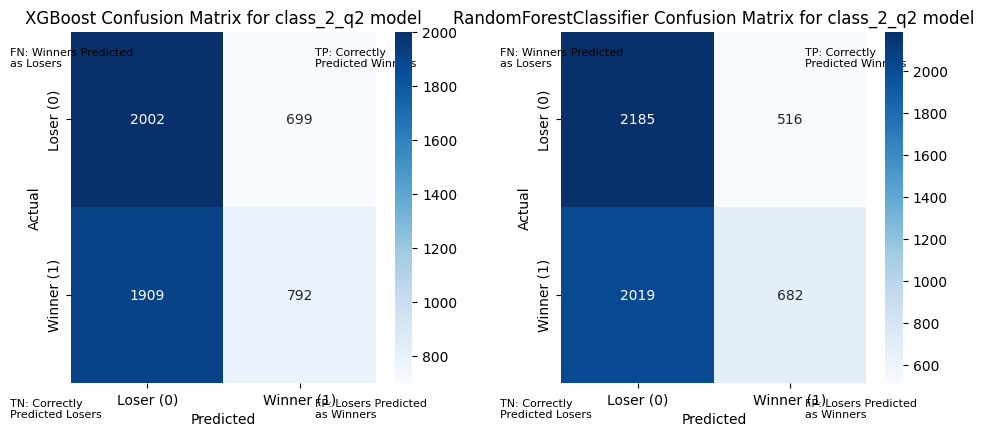


Detailed metrics for XGBoost prediction class_2_q2:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.512   0.741     0.606   2701.0
Winner (1)      0.531   0.293     0.378   2701.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 2002
False Positives (Losers Predicted as Winners): 699
False Negatives (Winners Predicted as Losers): 1909
True Positives (Correctly Predicted Winners): 792

Detailed metrics for RandomForestClassifier prediction class_2_q2:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.520   0.809     0.633   2701.0
Winner (1)      0.569   0.252     0.350   2701.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 2185
False Positives (Losers Predicted as Winners): 516
False Negatives (Winners Predicted as Losers): 2019
True Positives (Correctly Predicted Winners): 682
class_2_q3
p=

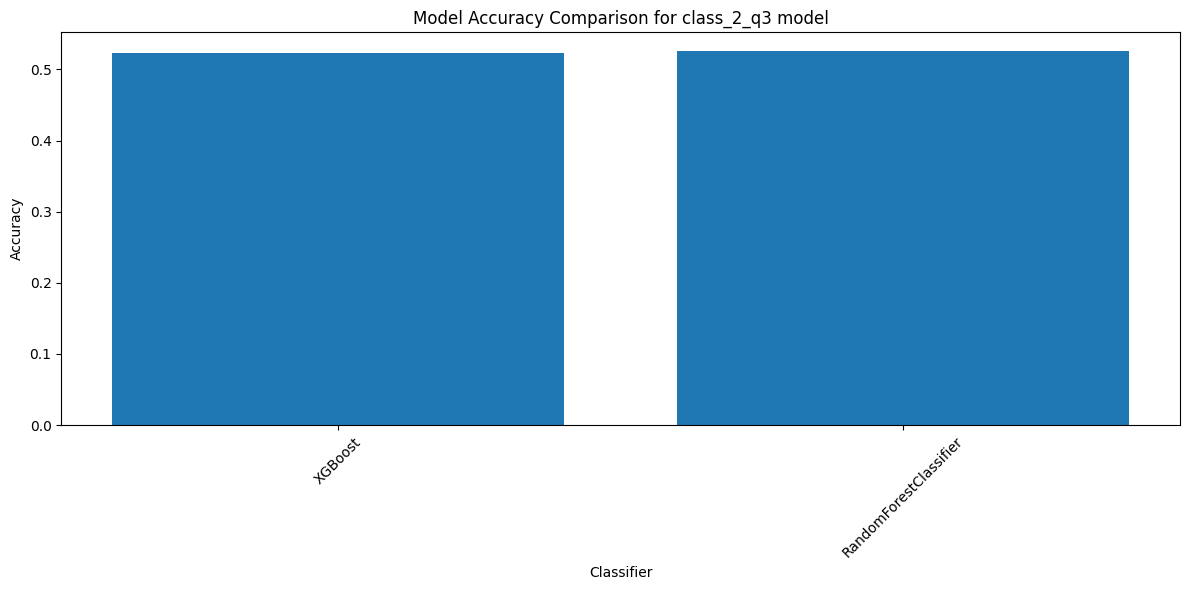

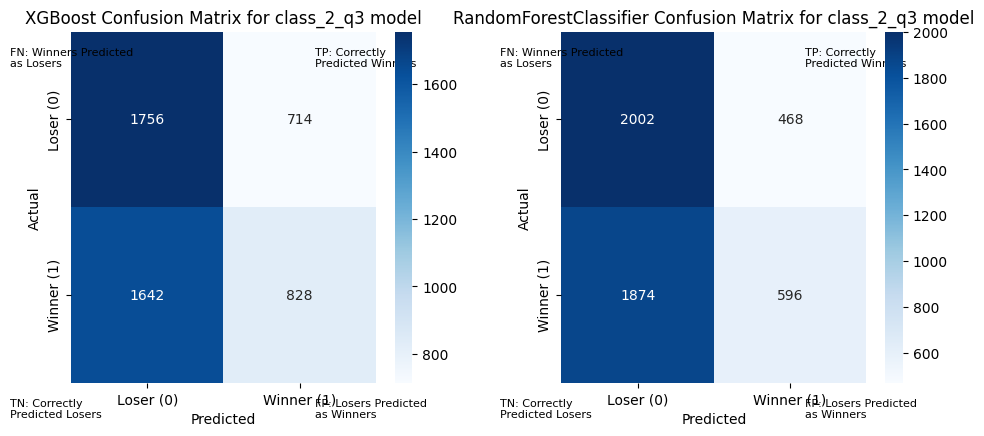


Detailed metrics for XGBoost prediction class_2_q3:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.517   0.711     0.599   2470.0
Winner (1)      0.537   0.335     0.413   2470.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 1756
False Positives (Losers Predicted as Winners): 714
False Negatives (Winners Predicted as Losers): 1642
True Positives (Correctly Predicted Winners): 828

Detailed metrics for RandomForestClassifier prediction class_2_q3:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.517   0.811     0.631   2470.0
Winner (1)      0.560   0.241     0.337   2470.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 2002
False Positives (Losers Predicted as Winners): 468
False Negatives (Winners Predicted as Losers): 1874
True Positives (Correctly Predicted Winners): 596
class_2_q4
p=

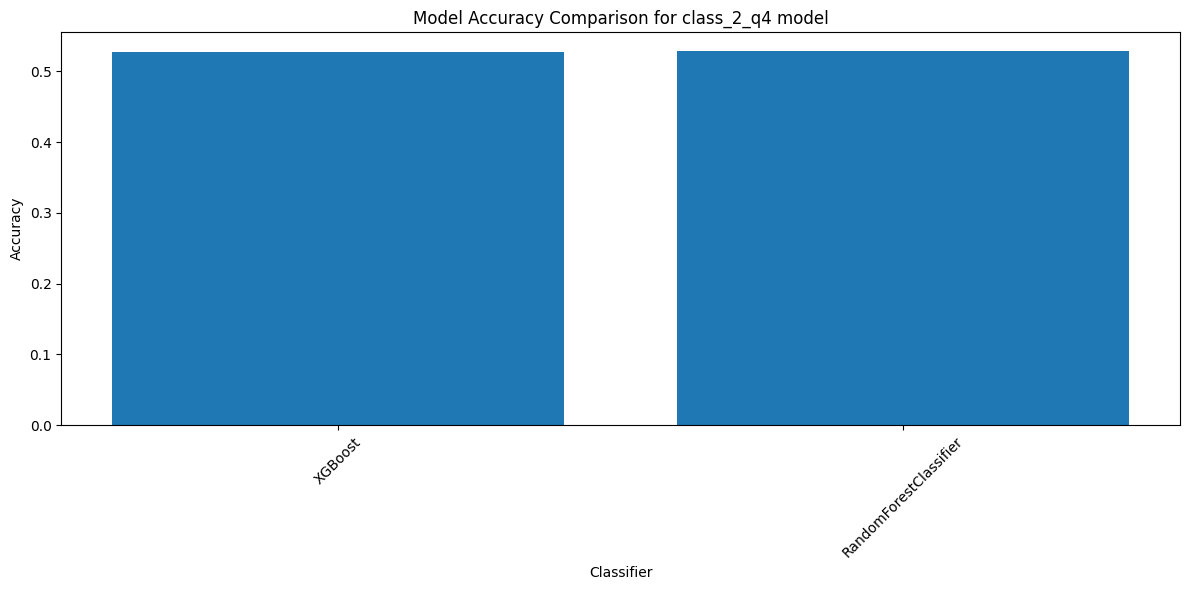

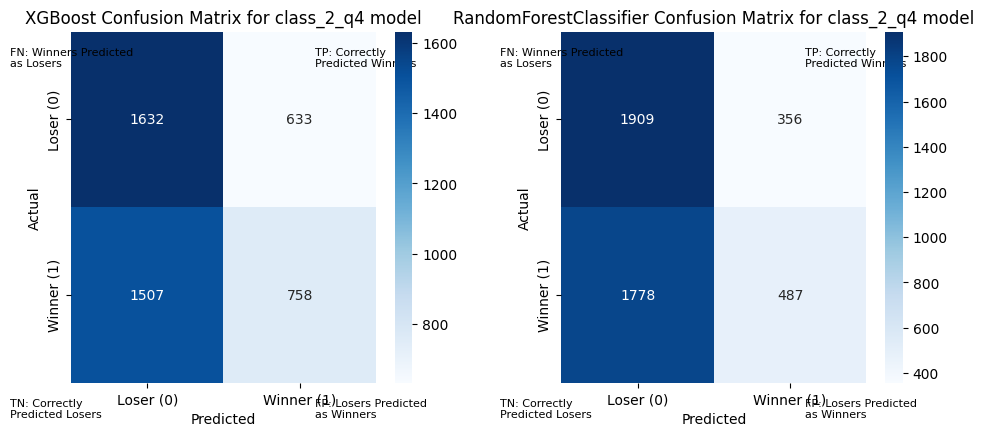


Detailed metrics for XGBoost prediction class_2_q4:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.520   0.721     0.604   2265.0
Winner (1)      0.545   0.335     0.415   2265.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 1632
False Positives (Losers Predicted as Winners): 633
False Negatives (Winners Predicted as Losers): 1507
True Positives (Correctly Predicted Winners): 758

Detailed metrics for RandomForestClassifier prediction class_2_q4:
            Precision  Recall  F1-Score  Support
Class                                           
Loser (0)       0.518   0.843     0.641   2265.0
Winner (1)      0.578   0.215     0.313   2265.0

Confusion Matrix Interpretation:
True Negatives (Correctly Predicted Losers): 1909
False Positives (Losers Predicted as Winners): 356
False Negatives (Winners Predicted as Losers): 1778
True Positives (Correctly Predicted Winners): 487


In [54]:
enable_credit_data = True
test_size=0.2
verbose=4

for decision_attr in model_decision_attrs:
    print(decision_attr)
    selected_attrs =  open(f"feature_selection_for_{decision_attr}-selected.txt").read().split("\n")[:-1] + ["sector", decision_attr]
    selected_attrs = list(set(selected_attrs))
    XY_selected = XY[selected_attrs].dropna(subset=[decision_attr]).dropna(axis=1)
    XY_selected = XY_selected[~XY_selected.isin([np.inf, -np.inf]).any(axis=1)]
    X = XY_selected.drop(columns=[decision_attr])
    X = pd.get_dummies(X, columns=["sector"])
    Y = XY_selected[decision_attr]
    print("p=", len(X.columns))
    print("n=", len(X))
    
    results, X_test, y_test = train_and_evaluate_classifiers(
        X,Y, test_size=test_size, verbose=verbose, n_iter=3, n_splits=4, random_state=22
    )
    plot_results(results, X_test, y_test, decision_attr)
    